# VIC Hydrologic Model Tutorial

**Authors**: Felix Kasiti  

This tutorial demonstrates how to set up and run the Variable Infiltration Capacity (VIC) model version 4.2 along with a routing model (based on Lohmann et al.) for the 1KA42 Basin in Tanzania. 

## Prerequisites
- Introduction to GIS
- Introduction to Remote Sensing
- Basic knowledge of hydrology/hydrologic modelling
- Basic programming knowledge(python)
- Basic linux commands

## Required Software
- QGIS 2.8 or higher or ArcGIS
- Python 3.6+
- GDAL
- Numpy
- Scipy
- Pandas

## Data Materials
All input files should be located in the 'data' folder (XXXX/XXXX/data):
1. Elevation data (SRTM)
2. Land cover data (MODIS)
3. Soils data (HWSD)
4. Slope
5. Annual precipitation climatology (CHIRPS)
6. Leaf Area Index (LAI)
7. Albedo
8. Basin shapefile (Delineated Shapefile)
9. Daily precipitation data
10. Maximum and minimum temperature and windspeed

### Input files preparation scripts from Google Earth Engine

Data preparation for input files has been simplified and will be pre-processed from GEE
Here are the scripts that are needed to prepare input files, run each script, export to google drive, and download and save to vic folder(raw)
- DEM, Landcover, Soil, Slope, Annual precipitation https://code.earthengine.google.com/5997904b7080c8e41da7bd3163370325?noload=true
- LAI: https://code.earthengine.google.com/806f812e00a07ad5efbc577e3d75d847?noload=true
- ALBEDO : https://code.earthengine.google.com/2d11baf15b7d08708604030604144758?noload=true
- Dily precip data:  https://www.chc.ucsb.edu/data
- Tmax, Tmin, uwind vwind from NCEP: https://psl.noaa.gov/thredds/catalog/catalog.html
- Breif video guides on basic setups:
    -  https://youtu.be/08uVoB_tBLA
    -  https://youtu.be/08uVoB_tBLA
    -  https://youtu.be/Xg7MX9q4eac
    -  https://youtu.be/lCJwYMlxuew

### Folder structure and where to store data
 - All downloaded data from the GEE script to be stored on the raw folder
 - All downloaded chirps and tmax,tmin data to be stored in met_raw


<img alt="first image" src="folder_structure.png" width=500>


In [2]:
# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import aoi_grid_utils
from Raster_band_split_final import split_raster_bands
from snap_raster import snap_raster
from aoi_grid_utils import create_aoi_grid, create_grid_from_bounds
from format_snow_params import format_snow_params
from make_veg_lib import make_veg_lib
from format_veg_params import format_veg_params
from format_meteo_forcing_chirps_final import format_meteo_forcing
from format_soil_params import format_soil_params
import rasterio as io
from matplotlib import pyplot
from read_text_file import read_file
import glob

# %matplotlib inline

In [3]:
os.chdir(os.getcwd())

In [2]:
## define paths
in_path = 'G:\\1KA42\\data\\input\\raw\\'
out_path = 'G:\\1KA42\\data\\input\\gis\\'

## 1. Create Grid Template

First, we'll create our underlying grid template using the basin shapefile.

Create_aoi_grid.py  creates a raster grid over an input shapefile with a user specified cell size. 

- Usage: python create_aoi_grid.py <input #shapefile> <output #raster file> <output# cell size> 	 
 
* 0.05 indicates cell size in decimal degrees 


G:\1KA42\data\input\gis\1KA42_grid.tif


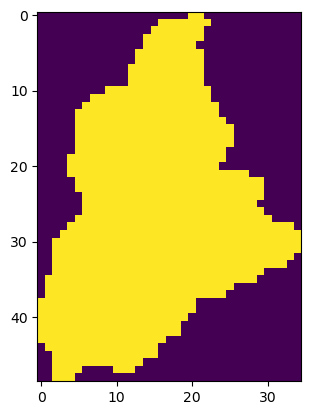

In [3]:
# Set working directory to scripts folder
# os.chdir('../scripts/')
watershed = in_path + '1KA42.shp'
grid = out_path + '1KA42_grid.tif'
print(grid)
# Create grid template
create_grid = create_aoi_grid(watershed,  grid, 0.05)
## read it and plot the created grid
# note that the grid hasindividual pixel of 0.05 degree as specified above
src = io.open(grid)
pyplot.imshow(src.read(1))

## 2. Align Input Raster Data

Next, we'll align all input raster datasets to our grid template.
- Snap_raster.py aligns the grid cells of two rasters resamples if needed. 
 	 
*Usage: python snap_raster.py <input 'raster'> <output 'raster'> <template 'raster'> <sub 'grid'  	 	  	 
 Boolean> <resampling 'method'>  
*	After aligning data, pull new .tif files into QGIS and make sure the alignment is correct. 


G:\1KA42\data\input\gis\1KA42_grid.tif


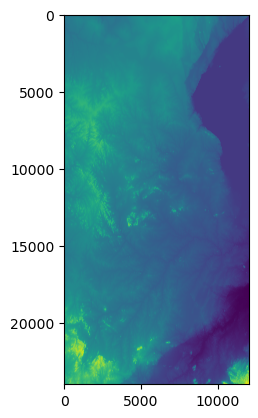

In [4]:
# Align elevation data
##input raw DEM
raw_DEM = in_path + 'DEM.tif'
#grid
grid = out_path + '1KA42_grid.tif'
print(grid)
# output snapped DEM
SRTMSnap = out_path + 'SRTMSnap.tif'
## resample
resample = 'bilinear'
snap_raster(raw_DEM,SRTMSnap,grid, 'True', resample)

src = io.open(SRTMSnap)
pyplot.imshow(src.read(1))

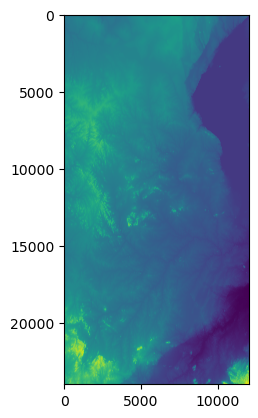

In [5]:
# Calculate elevation average

ElvAvg = out_path + '1KA42_ElvAvg.tif'
#grid
grid = out_path + '1KA42_grid.tif'

# output snapped DEM
SRTMSnap = out_path + 'SRTMSnap.tif'
#resample
resample = 'mean'

snap_raster(SRTMSnap,ElvAvg,grid, 'False', resample)

src = io.open(SRTMSnap)
pyplot.imshow(src.read(1))

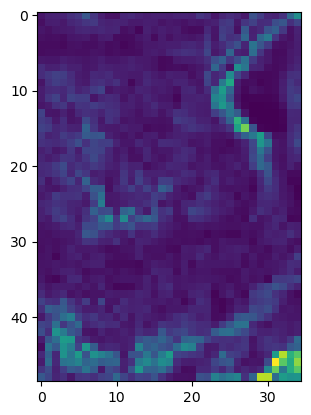

In [6]:
# Process slope data
#input slope file
in_slope = in_path + 'Slope.tif'
## output slope
SlopeAvg = out_path + '1KA42_SlopeAvg.tif'

#grid
grid = out_path + '1KA42_grid.tif'

#resample
resample = 'mean'

snap_raster(in_slope, SlopeAvg,grid, 'False', resample)

src = io.open(SlopeAvg)
pyplot.imshow(src.read(1))


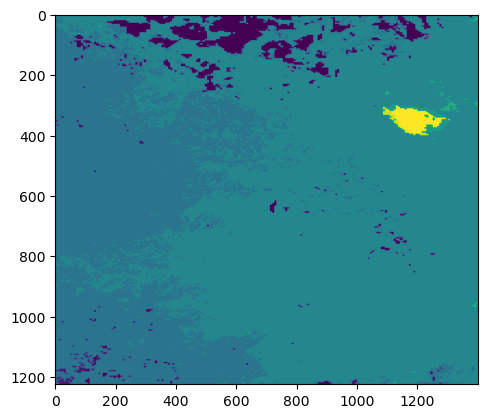

In [61]:
# Process land cover data

#Lancover data
landcover = in_path + 'Land_Cover_IGBP.tif'
## output lcdata
landcover_out = out_path + '1KA42_LC_IGBP.tif'

#grid
grid = out_path + '1KA42_grid.tif'

#resample
resample = 'nearest'

snap_raster(landcover, landcover_out,grid, 'True', resample)

src = io.open(landcover_out)
pyplot.imshow(src.read(1))

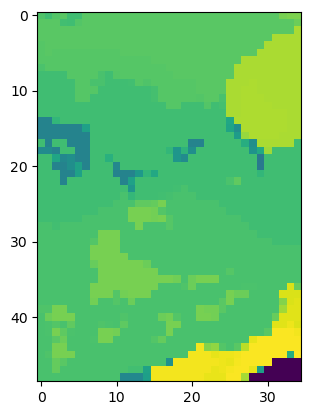

In [7]:
# Process soils data

#Soil in file
in_soil = in_path + 'HWSD_Soils.tif'
## output soil aggregate
SoilsAgg = out_path + '1KA42_SoilsAgg.tif'

#grid
grid = out_path + '1KA42_grid.tif'

#resample
resample = 'mode'

snap_raster(in_soil, SoilsAgg,grid, 'False', resample)

src = io.open(SoilsAgg)
pyplot.imshow(src.read(1))


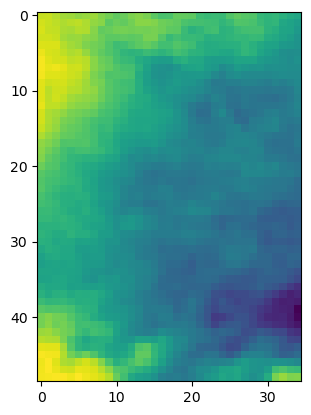

In [8]:
# Process precipitation data
# !python snap_raster.py <in precip> <out_precip> grid false mean
#Precip in
in_precip = in_path + 'Mean_Annual_Precipitation.tif'
## output precip
PrecipSnap = out_path + '1KA42_PrecipSnap.tif'

#grid
grid = out_path + '1KA42_grid.tif'

#resample
resample = 'mean'

snap_raster(in_precip, PrecipSnap,grid, 'False', resample)

src = io.open(PrecipSnap)
pyplot.imshow(src.read(1))


In [9]:
##SEPARATE LAI AND ALB into individual monthly files

LAI_RAW = in_path + 'model_parameter_lai.tif'
## OUT DIRECTORIES
LAI_OUT = out_path + '..\\ancilliary\\LAI\\'
in_file = 'LAI'
split_LAI = split_raster_bands(LAI_RAW,in_file, LAI_OUT)

ALB_RAW = in_path + 'model_parameter_alb.tif'
ALB_OUT = out_path + '..\\ancilliary\\ALB\\'
in_file = 'ALB'
split_ALB = split_raster_bands(ALB_RAW, in_file, ALB_OUT)


Saved band 1 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_1.tif
Saved band 2 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_2.tif
Saved band 3 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_3.tif
Saved band 4 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_4.tif
Saved band 5 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_5.tif
Saved band 6 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_6.tif
Saved band 7 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_7.tif
Saved band 8 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_8.tif
Saved band 9 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_9.tif
Saved band 10 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_10.tif
Saved band 11 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_11.tif
Saved band 12 to: G:\1KA42\data\input\gis\..\ancilliary\LAI\LAI_12.tif
Saved band 1 to: G:\1KA42\data\input\gis\..\ancilliary\ALB\ALB_1.tif
Saved band 2 to: G:\1KA42\data\input\gis\..\ancilliary\ALB\ALB_2.tif
Saved band 3 to: G:\1KA42\da

## 3. Format Input Files for VIC Model

Now we'll format our input files into VIC-readable format.

### Format snow params 	
takes geotiff data for snow band parameterization and converts it to the needed text format for the VIC model.  
 
*Usage: python format_snow_params.py <template raster> <elevation raster> <output snow  band file (snow.param)> < 	equal interval for snow bands (in meters)> 
*Script will  	output number of maximum bands. This is used to set a parameter in the global  parameter file 


In [10]:
### define new location sto store param files ... refer to folder structure
in_path = 'G:\\1KA42\\data\\input\\gis\\'
out_path = 'G:\\1KA42\\data\\input\\params\\'

In [11]:
# Format elevation band file
### Remeber to note the number of elevation profiles
#grid
grid = in_path + '1KA42_grid.tif'
# output snapped DEM
SRTMSnap = in_path + 'SRTMSnap.tif'
##output snow param file
snow_param = out_path + 'snow.param'

snow_file = format_snow_params(grid, SRTMSnap, snow_param, 100)


Number of maximum bands: 7


In [12]:
snow_file1= read_file(snow_param,file_type='txt',header=None)
snow_file1

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0,1446.4215,0.0000,...,0.0,0.0,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0,NaN
1,2,0.0323,0.9677,0.0,0.0,0.0,0.0,0.0,1389.3485,1443.9719,...,0.0,0.0,0.0323,0.9677,0.0,0.0,0.0,0.0,0.0,NaN
2,3,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0,1369.4165,0.0000,...,0.0,0.0,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0,NaN
3,4,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0,1377.8289,0.0000,...,0.0,0.0,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0,NaN
4,5,0.9733,0.0267,0.0,0.0,0.0,0.0,0.0,1385.3895,1400.5897,...,0.0,0.0,0.9733,0.0267,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,921,0.1665,0.8335,0.0,0.0,0.0,0.0,0.0,1196.6869,1210.9594,...,0.0,0.0,0.1665,0.8335,0.0,0.0,0.0,0.0,0.0,NaN
921,922,0.5493,0.4507,0.0,0.0,0.0,0.0,0.0,1191.1670,1207.0253,...,0.0,0.0,0.5493,0.4507,0.0,0.0,0.0,0.0,0.0,NaN
922,923,0.2670,0.7330,0.0,0.0,0.0,0.0,0.0,1293.5933,1314.0428,...,0.0,0.0,0.2670,0.7330,0.0,0.0,0.0,0.0,0.0,NaN
923,924,0.9553,0.0447,0.0,0.0,0.0,0.0,0.0,1279.9058,1303.8478,...,0.0,0.0,0.9553,0.0447,0.0,0.0,0.0,0.0,0.0,NaN


### Format soil params  	
takes geotiff data for soil parameterization and converts it to the needed text format for the VIC model. 	 
*Usage: python format_soil_params.py <template raster> <soil classification raster> <elevation  raster> <annual precip raster> <slope raster> <output soil parameter file (soil.param)> 

In [13]:
# Format soil parameter file
#grid
grid = in_path + '1KA42_grid.tif'
SoilsAgg = in_path + '1KA42_SoilsAgg.tif'
ElvAvg = in_path + '1KA42_ElvAvg.tif'
PrecipSnap = in_path + '1KA42_PrecipSnap.tif'
SlopeAvg = in_path + '1KA42_SlopeAvg.tif'
##out soil params file
soil_param = out_path + 'soil.param'
soil_file = format_soil_params(grid, SoilsAgg, ElvAvg, PrecipSnap, SlopeAvg, soil_param)


In [14]:
soil_file= read_file(soil_param,file_type='txt',header=None)
soil_file

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,1,21,-5.4379,34.7268,0.1,0.3,2.6106,0.95,2,27.56,...,0.574468,0.574468,0.574468,0.01,0.001,1519.038399,0.090,0.0900,0.0900,1
1,1,22,-5.4379,34.7775,0.1,0.3,4.4505,0.95,2,27.56,...,0.574468,0.574468,0.574468,0.01,0.001,1452.514963,0.090,0.0900,0.0900,1
2,1,52,-5.4885,34.5238,0.1,0.3,1.5798,0.95,2,27.56,...,0.574468,0.574468,0.574468,0.01,0.001,1550.291378,0.090,0.0900,0.0900,1
3,1,53,-5.4885,34.5746,0.1,0.3,1.9701,0.95,2,27.56,...,0.574468,0.574468,0.574468,0.01,0.001,1539.749170,0.090,0.0900,0.0900,1
4,1,54,-5.4885,34.6253,0.1,0.3,1.8056,0.95,2,27.56,...,0.574468,0.574468,0.574468,0.01,0.001,1523.816739,0.090,0.0900,0.0900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,1,1657,-7.8124,34.2701,0.1,0.3,0.9352,0.95,2,20.32,...,0.435897,0.560976,0.560976,0.01,0.001,1482.607586,0.068,0.0109,0.0109,1
921,1,1658,-7.8124,34.3209,0.1,0.3,7.6284,0.95,2,27.56,...,0.574468,0.574468,0.574468,0.01,0.001,1437.098718,0.090,0.0900,0.0900,1
922,1,1683,-7.8629,33.8135,0.1,0.3,1.1082,0.95,2,20.32,...,0.435897,0.560976,0.560976,0.01,0.001,1787.955852,0.068,0.0109,0.0109,1
923,1,1684,-7.8629,33.8643,0.1,0.3,1.5207,0.95,2,20.32,...,0.435897,0.560976,0.560976,0.01,0.001,1785.582724,0.068,0.0109,0.0109,1


### Format_veg_params.py  	
takes geotiff data for vegetation parameterization and converts it to  the needed text format for the VIC model. 
*Usage: python format_veg_params.py <template raster> <land cover raster> <output veg  parameter file (veg.param)> <land cover classification scheme>  
*	IGBP stands for the International  	Geosphere-Biosphere Programme. For more information visit: www.igbp.net 	 

In [16]:
# Format vegetation parameter file 
#grid
grid = in_path + '1KA42_grid.tif'
LC_IGBP = in_path + '1KA42_LC_IGBP.tif'
##out soil params file
veg_param = out_path + 'veg.param'
scheme = 'IGBP'
format_veg_params(grid,LC_IGBP, veg_param, scheme)


### Make vegetation library	
Takes geotiff data for the vegetation library file and converts it to the needed text format for the VIC model. 


* Usage: Format meteorological forcing files:
make_veg_lib.py <land 'cover raster> <LAI data' folder> <albedo data' folder>  
python format_meteo_forcing.py <output veg lib file (veg.lib)> <land cover classification scheme


In [17]:
# Setup vegetation library file
## OUT DIRECTORIES
LC_IGBP = in_path + '1KA42_LC_IGBP.tif'
Alb_dir = out_path + '..\\ancilliary\\ALB\\'
LAI_dir = out_path + '..\\ancilliary\\ALB\\'
veg_lib = out_path + 'veg.lib'
scheme = 'IGBP'
print(LAI_dir)
make_veg_lib(LC_IGBP, LAI_dir, Alb_dir,veg_lib, scheme)


G:\1KA42\data\input\params\..\ancilliary\ALB\


### Format meteo forcing

writes a time series for precip, tmax, tmin and wind for each grid cell to run VIC 
 
 *Usage: python format_meteo_forcing.py <'template raster> <met 'data input path> <forcing'  file out path> <start' year> <end' year> 
*This script will need to be updated for your specific application, particularly reading in the 
 
meteorological data depending on the format. *In this example 2005 – 2013 is the date range 


In [18]:
### set meteo directories
chirp_dir = out_path + '..\\met_raw\\chirps\\'
tem_wind_dir = out_path + '..\\met_raw\\temp_wind\\'

In [19]:
# Format meteorological forcing files
# !python format_meteo_forcing.py 
# ../data/input/gis/Nyando_grid.tif 
# ../data/input/forcing/raw/ 
# ../data/input/forcing/ 2005 2013
#grid
grid = in_path + '1KA42_grid.tif'
### forcings output dir =
forcing_dir = in_path + '..\\forcings\\'
### create forcings
format_meteo_forcing(grid,chirp_dir, tem_wind_dir,  forcing_dir, 2010,2010)

Generating Forcings


In [22]:
forcings = glob.glob(in_path + '..\\forcings\\' + '*')
forcing_file = forcings[0]
forcing_file= read_file(forcing_file,file_type='txt',header=None)
forcing_file # First column is Precipitation Second Tmax Tmin and windspeed


,0,1,2,3
0,0.00,28.25,15.35,0.9735
1,18.44,23.75,16.05,0.5545
2,18.44,22.95,16.05,0.3081
3,18.44,22.45,16.25,0.6121
4,12.29,22.15,15.45,0.8251
...,...,...,...,...
360,0.00,29.65,14.05,1.8165
361,0.00,29.65,14.05,1.5652
362,0.00,28.75,15.15,2.0150
363,0.00,28.75,14.75,2.5152


## 4. Run VIC Model

Since we have finished preparing all the input files, we are not ready to run VIC. But!! We need to specify a few paramsters on the global parameter file.

-	We have most of the files needed
-	Update the global parameter file to run the model for 2010– 2010 
-   Update paths to the input files and output file directory 
-   It is best to  use absolute paths within the global parameter file when running the VIC executable file
-   Ensure the start and end year are correct as per your input datasets
#### In the next step, VIC will be run in a linux environment

<img alt="first image" src="global_3.png" width=500> <img alt="second image" src="global_1.png" width=500><img alt="third image" src="global_2.png" width=500> 


# Change directory to where VIC executable is located
# Run VIC model
- ./vicNl -g ./input/global.params
- The screenshot below is an example when run on Ubuntu windows subsystem.
- 
<img alt="third image" src="run_vic.png" width=500>



In [24]:
### read flux files
flux_dir = glob.glob('G:\\1KA42\\data\\output\\fluxes\\*')
#####
flux_file = flux_dir[0]
flux_file= read_file(flux_file,file_type='txt',header=None)
flux_file 
### Year Month Day PREC	EVAP	RUNOFF	BASEFLOW	SWE	SOIL_MOIST
### 

,0,1,2,3,4,5,6,7,8,9,10
0,2010,1,1,0.00,2.4038,0.0000,2.6106,0.0,42.2198,701.4256,140.2851
1,2010,1,2,18.44,1.6675,13.4077,2.6106,0.0,42.9561,701.4256,140.2851
2,2010,1,3,18.44,3.1490,11.0129,2.6106,0.0,44.6236,701.4256,140.2851
3,2010,1,4,18.44,3.3431,12.4863,2.6106,0.0,44.6236,701.4256,140.2851
4,2010,1,5,12.29,3.7501,5.9293,2.6106,0.0,44.6236,701.4256,140.2851
...,...,...,...,...,...,...,...,...,...,...,...
360,2010,12,27,0.00,1.6238,0.0000,0.1324,0.0,38.5050,508.3769,45.2165
361,2010,12,28,0.00,1.6938,0.0000,0.1327,0.0,37.8359,507.1805,45.2554
362,2010,12,29,0.00,1.5084,0.0000,0.1330,0.0,37.3740,505.9706,45.2859
363,2010,12,30,0.00,1.4199,0.0000,0.1332,0.0,37.0053,504.7649,45.3073


## 5. Run Routing Model
Coming soon!


## 7. Model Calibration
- Coming Soon
- Calibration using Shuffled Complex Evolution (SCE-UA) Method.